In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)

### Your task is to find a way to reliably identify which routes (if any) show changes.

In [2]:
df = pd.read_csv('df.csv')
# These fix formatting issues.
df.drop('Unnamed: 0', axis=1, inplace=True)
df['starttime'] = df['starttime'].apply(lambda x: x[1:-1].split(','))
df['month'] = df['starttime'].apply(lambda x: int(x[1]))
df['date'] = pd.to_datetime(df['starttime'].apply(lambda x: ' -'.join(x[:3])))

In [3]:
# import pickle
# filename = "bikedata.pickle"
# with open(filename, 'rb') as f:
#     data_final = pickle.load(f)
# new = [data_final[0][i][j] for i in range(len(data_final[0])) for j in range(6)]
# date_time = [new[i:i + 6] for i in range(0, len(new), 6)]
# df['starttime'] = date_time
# df.to_csv('df.csv')

In [4]:
weather = pd.read_csv('Washington 2010-09-20 to 2011-12-31.csv')
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather[['datetime','temp', 'conditions']]

### Data Cleaning

In [5]:
sum(df['station_start'] == df['station_end'])
# around 60k people rerack their bike at the same station. Doesn't help with our analysis of routes. 

62104

In [6]:
# Remove all of these.
df = df[df['station_start'] != df['station_end']]

In [7]:
 # Create a new column that can be used for convenience.
df['route'] = df['start_addy'] + ' ' + df['addy_end']

In [8]:
# Isolate our analysis to the top 500 most popular routes to minimize noise and maximize signal.
top_500 = df[df['route'].isin(df['route'].value_counts()[:500].index)]

In [9]:
top_500.groupby('day_of_week')['duration'].mean()
# Longer ride durations over the weekend.

day_of_week
Friday       632.103095
Monday       677.160879
Saturday     891.927312
Sunday       867.202605
Thursday     602.786493
Tuesday      612.332925
Wednesday    584.143047
Name: duration, dtype: float64

In [10]:
top_500.head()

starttime  duration  bikenum  station_start  \
0    [2010,  9,  20,  11,  27,  4]      1012    742.0          31208   
2    [2010,  9,  20,  12,  5,  37]      2690    993.0          31600   
4   [2010,  9,  20,  12,  10,  43]      1413    883.0          31100   
5   [2010,  9,  20,  12,  14,  27]       982    850.0          31109   
15  [2010,  9,  20,  12,  39,  35]       351    685.0          31103   

                       start_addy                              addy_end  \
0        M St & New Jersey Ave SE                         4th & M St SW   
2                   5th & K St NW         19th St & Pennsylvania Ave NW   
4   19th St & Pennsylvania Ave NW                        15th & P St NW   
5                   7th & T St NW  Massachusetts Ave & Dupont Circle NW   
15           16th & Harvard St NW           Adams Mill & Columbia Rd NW   

    station_end  member  days_since_Jan1_2010 day_of_week  month       date  \
0         31108    True                   262      Monday      9 2010-09-20   
2         31100    True                   262      Monday      9 2010-09-20   
4         31201    True                   262      Monday      9 2010-09-20   
5         31200    True                   262      Monday      9 2010-09-20   
15        31104    True                   262      Monday      9 2010-09-20   

                                                route  
0              M St & New Jersey Ave SE 4th & M St SW  
2         5th & K St NW 19th St & Pennsylvania Ave NW  
4        19th St & Pennsylvania Ave NW 15th & P St NW  
5   7th & T St NW Massachusetts Ave & Dupont Circl...  
15   16th & Harvard St NW Adams Mill & Columbia Rd NW

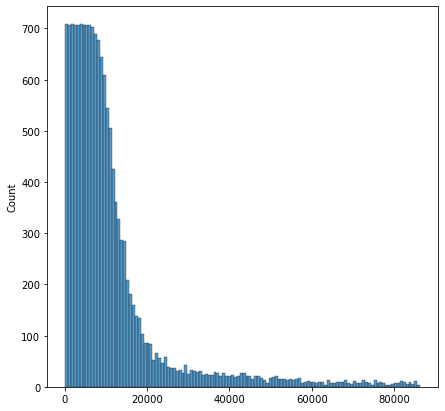

In [11]:
sns.histplot(df.duration.unique());

In [12]:
print(sum(df['duration'] > 43000))
print(sum(df['duration'] > 43000) / sum(df['duration']))

708
5.311221244951596e-07


These are outliers that could have high leverage. Doesn't make sense that a bike could be gone for over 22 hours. We should remove all the data with duration greater than 12 hours (43,000 seconds). 

In [13]:
df = df[df['duration'] < 43000]

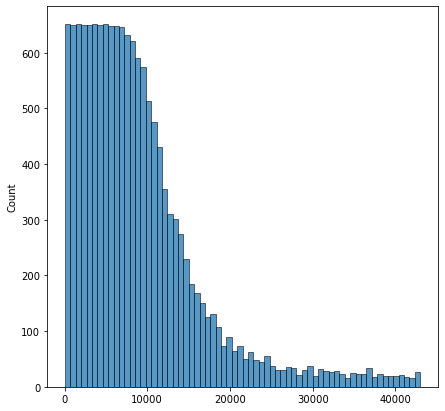

In [14]:
sns.histplot(df.duration.unique());

<AxesSubplot:title={'center':'Average duration for one route by month'}, xlabel='month'>

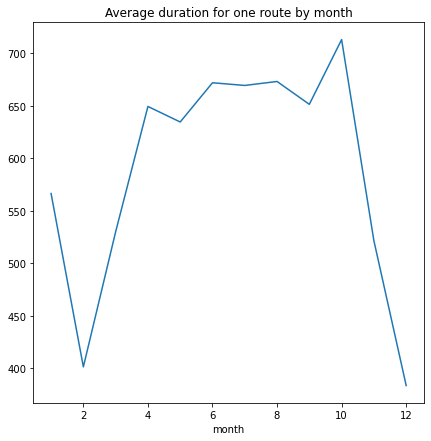

In [15]:
route = df[(df['station_start'] == 31200) & (df.station_end == 31201)]

plt.title('Average duration for one route by month')
route.groupby('month')['duration'].mean().plot()

Preliminary graph of the most popular route shows the unsurprising finding that people bike for less time when its colder.

In [16]:
df.groupby('member')['duration'].mean()
# So there is definitely a difference in riding times for members and non-members by about 3x more for non-members. Makes sense since they are likely touring places. 

member
False    2238.059276
True      736.994743
Name: duration, dtype: float64

In [17]:
temp = []
conditions = []
for i in range(len(weather)):
    num = sum(df['date'] == weather['datetime'][i])
    array = np.ones(num) * weather['temp'][i]
    cond = [weather['conditions'][i]] * num
    temp.append(array)
    conditions.append(cond)

temp_fin = []
for i in temp:
    temp_fin.extend(i)

temp_cond = []
for i in conditions:
    temp_cond.extend(i)

df['temperature'] = temp_fin
df['conditions'] = temp_cond

In [18]:
df.head()

starttime  duration  bikenum  station_start  \
0   [2010,  9,  20,  11,  27,  4]      1012    742.0          31208   
2   [2010,  9,  20,  12,  5,  37]      2690    993.0          31600   
3    [2010,  9,  20,  12,  6,  5]      1406    344.0          31600   
4  [2010,  9,  20,  12,  10,  43]      1413    883.0          31100   
5  [2010,  9,  20,  12,  14,  27]       982    850.0          31109   

                      start_addy                              addy_end  \
0       M St & New Jersey Ave SE                         4th & M St SW   
2                  5th & K St NW         19th St & Pennsylvania Ave NW   
3                  5th & K St NW               Park Rd & Holmead Pl NW   
4  19th St & Pennsylvania Ave NW                        15th & P St NW   
5                  7th & T St NW  Massachusetts Ave & Dupont Circle NW   

   station_end  member  days_since_Jan1_2010 day_of_week  month       date  \
0        31108    True                   262      Monday      9 2010-09-20   
2        31100    True                   262      Monday      9 2010-09-20   
3        31602    True                   262      Monday      9 2010-09-20   
4        31201    True                   262      Monday      9 2010-09-20   
5        31200    True                   262      Monday      9 2010-09-20   

                                               route  temperature  \
0             M St & New Jersey Ave SE 4th & M St SW         22.5   
2        5th & K St NW 19th St & Pennsylvania Ave NW         22.5   
3              5th & K St NW Park Rd & Holmead Pl NW         22.5   
4       19th St & Pennsylvania Ave NW 15th & P St NW         22.5   
5  7th & T St NW Massachusetts Ave & Dupont Circl...         22.5   

         conditions  
0  Partially cloudy  
2  Partially cloudy  
3  Partially cloudy  
4  Partially cloudy  
5  Partially cloudy